In [3]:
import torch
from torch import nn
from imagen_pytorch.imagen_pytorch import cast_uint8_images_to_float, resize_image_to, normalize_neg_one_to_one, GaussianDiffusionContinuousTimes, cast_tuple, pad_tuple_to_length, default
from utils import *
import matplotlib.pyplot as plt

def add_noise(images, image_sizes = (64, 64), timesteps=1000, times = 500):
    times = torch.tensor([times/timesteps])
    assert images.shape[-1] == images.shape[-2], f'the images you pass in must be a square, but received dimensions of {images.shape[2]}, {images.shape[-1]}'
    images = cast_uint8_images_to_float(images)
    assert images.dtype == torch.float or images.dtype == torch.half, f'images tensor needs to be floats but {images.dtype} dtype found instead'
    assert images.shape[1] == 3
    images = resize_image_to(images, image_sizes)
    x_start = images#normalize_neg_one_to_one(images)

    timesteps = cast_tuple(timesteps, 2)

    # make sure noise schedule defaults to 'cosine', 'cosine', and then 'linear' for rest of super-resoluting unets
    noise_schedules = 'cosine'
    noise_schedules = cast_tuple(noise_schedules)
    noise_schedules = pad_tuple_to_length(noise_schedules, 2, 'cosine')
    noise_schedules = pad_tuple_to_length(noise_schedules, 2, 'linear')

    noise_scheduler_klass = GaussianDiffusionContinuousTimes
    noise_schedulers = nn.ModuleList([])
    noise = default(None, lambda: torch.randn_like(x_start))

    for timestep, noise_schedule in zip(timesteps, noise_schedules):
        noise_scheduler = noise_scheduler_klass(noise_schedule = noise_schedule, timesteps = timestep)
        noise_schedulers.append(noise_scheduler)
    x_noisy, log_snr, alpha, sigma = noise_scheduler.q_sample(x_start = x_start, t = times, noise = noise)
    return x_noisy, log_snr, alpha, sigma

/home/hongn/miniconda3/envs/genai/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [51]:
# torch.zeros((1,)).float().uniform_(0, 1)

tensor([0.4171])

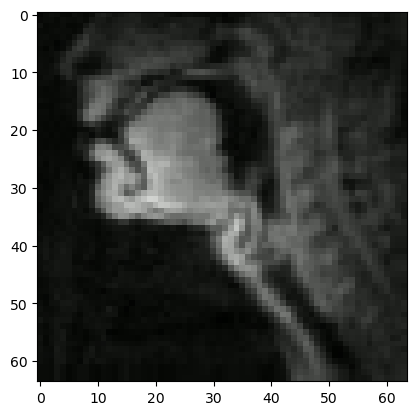

In [5]:
traindata = span75speaker(transform = data_transforms['val'])
(img, aud) = traindata[600000]
plt.imshow(img.permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


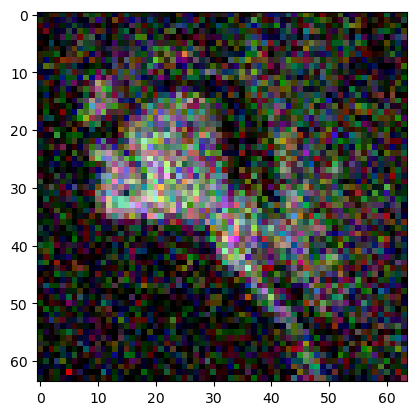

In [52]:
x_noisy, log_snr, alpha, sigma = add_noise(img.unsqueeze(0), image_sizes = (64, 64), timesteps=1000, times = 100)
plt.imshow(x_noisy[0].permute(1, 2, 0))

In [9]:
import torch
# from imagen_pytorch import Unet, Imagen
from imagen_pytorch import Unet, Imagen, ImagenTrainer

unet1 = Unet(
    dim = 32,
    cond_dim = 512,
    dim_mults = (1, 2, 4, 8),
    num_resnet_blocks = 3,
    layer_attns = (False, True, True, True),
    layer_cross_attns = (False, True, True, True)
)

unet2 = Unet(
    dim = 32,
    cond_dim = 512,
    dim_mults = (1, 2, 4, 8),
    num_resnet_blocks = (2, 4, 8, 8),
    layer_attns = (False, False, False, True),
    layer_cross_attns = (False, False, False, True)
)

# imagen, which contains the unets above (base unet and super resoluting ones)

imagen = Imagen(
    text_embed_dim=1024,
    unets = (unet1, unet2),
    image_sizes = (64, 64),
    timesteps = 1000,
    cond_drop_prob = 0.1
).cuda()

imagen.load_state_dict(torch.load('./imagen-span-070823'))
imagen.eval()

The base dimension of your u-net should ideally be no smaller than 128, as recommended by a professional DDPM trainer https://nonint.com/2022/05/04/friends-dont-let-friends-train-small-diffusion-models/


Imagen(
  (noise_schedulers): ModuleList(
    (0): GaussianDiffusionContinuousTimes()
    (1): GaussianDiffusionContinuousTimes()
  )
  (lowres_noise_schedule): GaussianDiffusionContinuousTimes()
  (unets): ModuleList(
    (0): Unet(
      (init_conv): CrossEmbedLayer(
        (convs): ModuleList(
          (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): Conv2d(3, 8, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
          (2): Conv2d(3, 8, kernel_size=(15, 15), stride=(1, 1), padding=(7, 7))
        )
      )
      (to_time_hiddens): Sequential(
        (0): LearnedSinusoidalPosEmb()
        (1): Linear(in_features=17, out_features=128, bias=True)
        (2): SiLU()
      )
      (to_time_cond): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=True)
      )
      (to_time_tokens): Sequential(
        (0): Linear(in_features=128, out_features=1024, bias=True)
        (1): Rearrange('b (r d) -> b r d', r=2)
      )
      (

In [85]:
# imagen = imagen.cuda()
# sample_img = imagen.sample(text_embeds = aud.unsqueeze(0).cuda(), batch_size = 1, return_pil_images = True, stop_at_unet_number=1, init_images=x_noisy.cuda(), skip_steps=)

0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

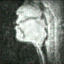

In [86]:
# sample_img[0]

# START INFERENCE

In [10]:
import librosa
import torch
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2Model

In [ ]:
# create_audio_emds(in_path = f'/mnt/c/Users/PCM/Dropbox/span/sub070/2drt/audio', out_path = './datasets/audios')

In [12]:
aud_embs = torch.load(f'./datasets/audios/sub070_2drt_12_picture1_video.pt')
aud_embs.shape
# sample_img = imagen.sample(text_embeds = aud.unsqueeze(0).cuda(), batch_size = 1, return_pil_images = True, stop_at_unet_number=1, init_images=x_noisy.cuda())

torch.Size([1, 1643, 1024])

In [44]:
x_noisy.shape

torch.Size([1, 3, 64, 64])

In [45]:
img.unsqueeze(0).shape

torch.Size([1, 3, 64, 64])

In [ ]:
x_noisy, log_snr, alpha, sigma = add_noise(img.unsqueeze(0), image_sizes = (64, 64), timesteps=1000, times = 50)
listimgs = []
!rm -rf vidgen_log
!mkdir vidgen_log
for i in range(400,600):
    print(i)
    aud = aud_embs[:,i,:]
    sample_img = imagen.sample(text_embeds = aud.unsqueeze(0).cuda(), batch_size = 128, return_pil_images = True, stop_at_unet_number=1, init_images=x_noisy.cuda(), skip_steps=800)
    x_noisy, log_snr, alpha, sigma = add_noise(x_noisy, image_sizes = (64, 64), timesteps=1000, times = 10)
    listimgs.append(sample_img)
    sample_img[0].save(f'./vidgen_log/sample-{i}.png')

In [56]:
listimages = [i[0] for i in listimgs]
listimages[0].save('./sample-skip800-noise30-feedback-dur100.gif', save_all=True, append_images=listimages[1:50], duration=100)

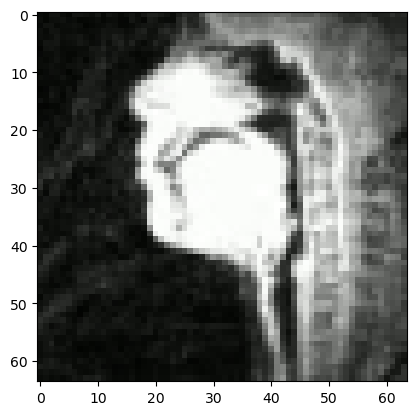

In [81]:
plt.imshow(img.permute(1, 2, 0))

In [74]:
sample_img.show()

AttributeError: 'list' object has no attribute 'show'

In [73]:
Image.show()

AttributeError: module 'PIL.Image' has no attribute 'show'